In [1]:
# import os
# import tarfile
# import shutil

# # Paths
# source_dir = r"C:\Users\wangh\cxr14"        # where your 12 .tar.gz files are
# output_dir = r"C:\Users\wangh\cxr14\images_all"  # where all .png files will go

# os.makedirs(output_dir, exist_ok=True)

# # Step 1: Extract all .tar.gz files
# for filename in os.listdir(source_dir):
#     if filename.endswith(".tar.gz"):
#         tar_path = os.path.join(source_dir, filename)
#         print(f"Extracting {tar_path}...")
#         with tarfile.open(tar_path, "r:gz") as tar:
#             tar.extractall(path=source_dir)

# # Step 2: Move all .png files to output_dir
# for root, dirs, files in os.walk(source_dir):
#     for file in files:
#         if file.lower().endswith(".png"):
#             src_path = os.path.join(root, file)
#             dst_path = os.path.join(output_dir, file)
#             shutil.move(src_path, dst_path)

# print("✅ Extraction and collection complete.")


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns


from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision

In [3]:
image_dir = r"C:\Users\wangh\cxr14\images_all"
label_path = r"D:\Downloads\Data_Entry_2017_v2020.csv"

df = pd.read_csv(label_path)
image_filenames = set(os.listdir(image_dir))

df['exists'] = df['Image Index'].apply(lambda x: x in image_filenames)
print("Total rows:", len(df))
print("Matched images:", df['exists'].sum())
print("Example unmatched:", df[df['exists'] == False].head())

Total rows: 112120
Matched images: 112120
Example unmatched: Empty DataFrame
Columns: [Image Index, Finding Labels, Follow-up #, Patient ID, Patient Age, Patient Sex, View Position, OriginalImage[Width, Height], OriginalImagePixelSpacing[x, y], exists]
Index: []


In [4]:
# -------------------------------
# CONFIGURATION
# -------------------------------
IMAGE_DIR = r"C:\Users\wangh\cxr14\images_all"
LABEL_FILE = r"D:\Downloads\Data_Entry_2017_v2020.csv"
EXPERT_VAL = r"D:\Downloads\four_findings_expert_labels_validation_labels.csv"
EXPERT_TEST = r"D:\Downloads\four_findings_expert_labels_test_labels.csv"
BATCH_SIZE = 128
NUM_WORKERS = 0
IMAGE_SIZE = 224
SAMPLE_FRAC = 1  # sample 10% of the training set

# -------------------------------
# 1. Load and Clean Main Label File
# -------------------------------
main_df = pd.read_csv(LABEL_FILE)
val_expert = pd.read_csv(EXPERT_VAL)
test_expert = pd.read_csv(EXPERT_TEST)

# Exclude expert-reviewed images from training
expert_indices = set(val_expert['Image Index']).union(set(test_expert['Image Index']))
main_df = main_df[~main_df['Image Index'].isin(expert_indices)].reset_index(drop=True)

# Assign binary labels: Pneumothorax = 1, No Finding = 0, ignore others
main_df['Finding Labels'] = main_df['Finding Labels'].fillna("No Finding")
main_df['Label'] = main_df['Finding Labels'].apply(
    lambda x: 1 if 'Pneumothorax' in x.split('|') else (0 if x.strip() == 'No Finding' else -1)
)
main_df = main_df[main_df['Label'] != -1].reset_index(drop=True)

# -------------------------------
# 2. Balanced Sampling of Training Set
# -------------------------------
pos_df = main_df[main_df['Label'] == 1]
neg_df = main_df[main_df['Label'] == 0]

# Sample same number from each class (controlled by SAMPLE_FRAC)
n_sample = int(min(len(pos_df), len(neg_df)) * SAMPLE_FRAC)
pos_sample = pos_df.sample(n=n_sample, random_state=42)
neg_sample = neg_df.sample(n=n_sample, random_state=42)

train_df = pd.concat([pos_sample, neg_sample]).sample(frac=1.0, random_state=42).reset_index(drop=True)
print(f"✅ Balanced training set: {len(train_df)} samples ({n_sample} pos / {n_sample} neg)")

# -------------------------------
# 3. Prepare Expert-Labeled Val/Test Sets
# -------------------------------
def clean_expert_labels(df):
    df['Label'] = df['Pneumothorax'].apply(lambda x: 1 if x == 'YES' else 0)
    return df

val_df = clean_expert_labels(val_expert)
test_df = clean_expert_labels(test_expert)

print(f"✅ Expert validation set: {len(val_df)}")
print(f"✅ Expert test set: {len(test_df)}")

# -------------------------------
# 4. Define PyTorch Dataset
# -------------------------------
class ChestXrayBinaryDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'Image Index']
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = float(self.df.loc[idx, 'Label'])
        return image, label, img_name


# -------------------------------
# 5. Transforms and Dataloaders
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = ChestXrayBinaryDataset(train_df, IMAGE_DIR, transform)
val_dataset = ChestXrayBinaryDataset(val_df, IMAGE_DIR, transform)
test_dataset = ChestXrayBinaryDataset(test_df, IMAGE_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"\n✅ Dataloaders ready.")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


✅ Balanced training set: 10128 samples (5064 pos / 5064 neg)
✅ Expert validation set: 2414
✅ Expert test set: 1962

✅ Dataloaders ready.
Train: 10128 | Val: 2414 | Test: 1962


In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained DenseNet-121
model = models.densenet121(pretrained=True)

# Replace classifier with binary classifier
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1)  # Output = 1 logit for binary classification

model = model.to(device)
model.load_state_dict(torch.load("121best_model.pt", map_location=device))

C:\Users\wangh\anaconda3\envs\mura-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wangh\anaconda3\envs\mura-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\wangh\AppData\Local\Temp\ipykernel_6520\523551796.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com

<All keys matched successfully>

In [6]:
from torch.optim import Adam
from sklearn.metrics import roc_auc_score

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler


scaler = GradScaler()

def train_one_epoch(model, dataloader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, labels, _ in loop:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        with autocast():  # AMP context
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader):
    model.eval()
    preds = []
    targets = []
    loop = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for images, labels , _ in loop:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()

            preds.extend(probs.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    auc = roc_auc_score(targets, preds)
    return auc

C:\Users\wangh\AppData\Local\Temp\ipykernel_6520\1908742458.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [7]:
# n_epochs = 2

# for epoch in range(n_epochs):
#     train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
#     val_auc = evaluate(model, val_loader)
#     print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val AUC: {val_auc:.4f}")

In [9]:
test_auc = evaluate(model, test_loader)
test_auc

0.8707500761830134

In [10]:
def plot_predictions_by_type(model, dataloader, device, pred_type='tp', max_display=100):
    """
    pred_type: one of ['tp', 'fp', 'fn']
    """
    model.eval()
    collected_images = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Finding {pred_type.upper()}s"):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).float()

            for i in range(len(labels)):
                pred = preds[i].item()
                label = labels[i].item()

                # Match condition
                if pred_type == 'tp' and pred == 1 and label == 1:
                    match = True
                elif pred_type == 'fp' and pred == 1 and label == 0:
                    match = True
                elif pred_type == 'fn' and pred == 0 and label == 1:
                    match = True
                else:
                    match = False

                if match:
                    img_np = images[i].detach().cpu().permute(1, 2, 0).numpy()
                    img_np = np.clip(img_np * np.array([0.229, 0.224, 0.225]) +
                                     np.array([0.485, 0.456, 0.406]), 0, 1)
                    collected_images.append(img_np)

                if len(collected_images) >= max_display:
                    break
            if len(collected_images) >= max_display:
                break

    # Plotting
    plot_image_grid(collected_images, max_display, title=pred_type.upper() + " Samples")


def plot_image_grid(image_list, max_display, title=""):
    cols = 10
    rows = int(np.ceil(max_display / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(20, 2.2 * rows))
    fig.suptitle(title, fontsize=16)

    for idx, ax in enumerate(axes.flat):
        if idx < len(image_list):
            ax.imshow(image_list[idx])
            ax.axis('off')
        else:
            ax.remove()

    plt.tight_layout()
    plt.show()

In [11]:
def show_images_from_loader(dataloader, class_names={0: "Normal", 1: "Abnormal"}):
    # Get one batch
    images, labels, _ = next(iter(dataloader))

    # Unnormalize (ImageNet mean/std)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean  # undo normalization

    # Show a grid of images
    grid_img = torchvision.utils.make_grid(images, nrow=4)
    plt.figure(figsize=(24, 14))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    titles = [class_names[int(l)] for l in labels[:8]]
    print("Labels:", titles)
    plt.show()

Labels: ['Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal']


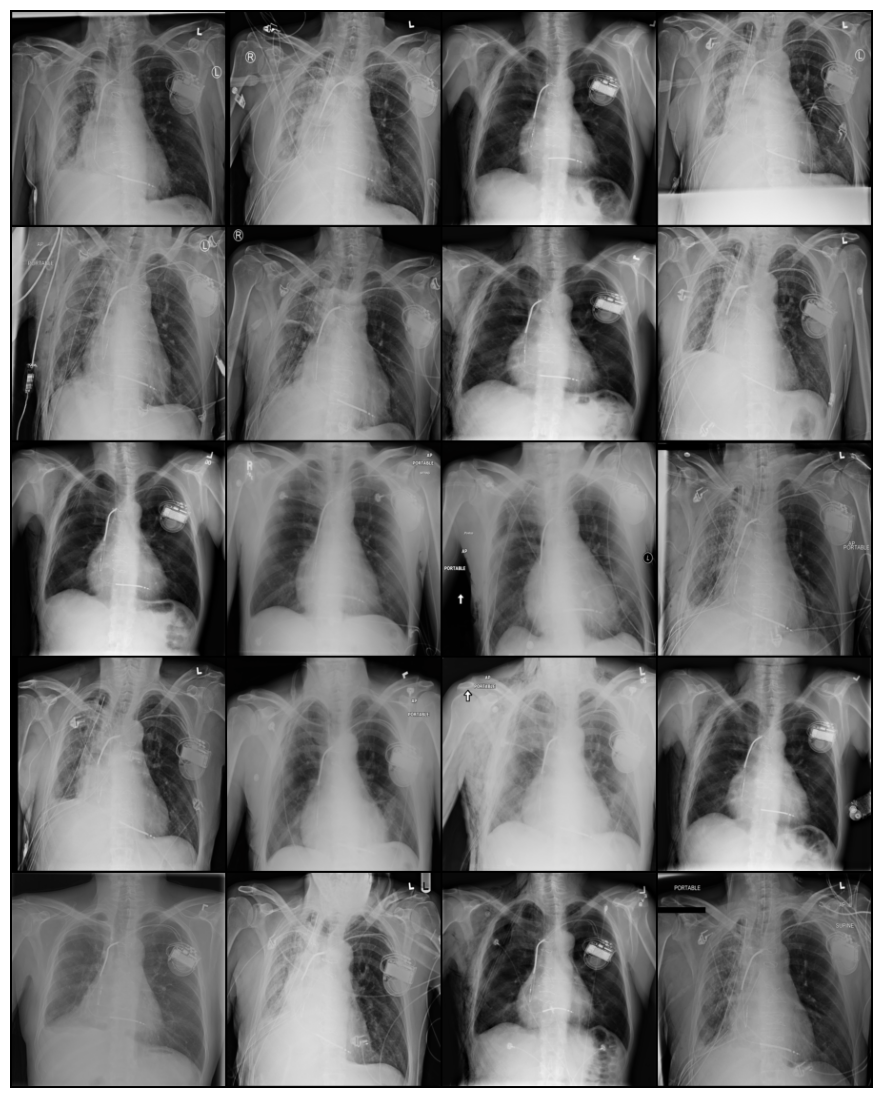

In [12]:
image_list =  ["00000013_001.png","00000013_002.png","00000013_003.png","00000013_004.png","00000013_005.png","00000013_006.png","00000013_007.png","00000013_008.png","00000013_009.png","00000013_010.png","00000013_011.png","00000013_012.png","00000013_013.png","00000013_014.png","00000013_015.png","00000013_016.png","00000013_017.png","00000013_018.png","00000013_019.png","00000013_020.png","00000013_021.png","00000013_022.png","00000013_023.png","00000013_024.png","00000013_025.png","00000013_026.png","00000013_027.png","00000013_028.png","00000013_029.png","00000013_030.png","00000013_031.png","00000013_032.png","00000013_033.png","00000013_034.png","00000013_035.png","00000013_036.png","00000013_037.png"]

sample = pd.concat([train_df[train_df['Image Index'].isin(image_list)],
                    val_df[val_df['Image Index'].isin(image_list)],
                    test_df[test_df['Image Index'].isin(image_list)],])

sample_dataset = ChestXrayBinaryDataset(sample, IMAGE_DIR, transform)

sample_loader = DataLoader(sample_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

show_images_from_loader(sample_loader)

In [ ]:
plot_predictions_by_type(model, test_loader, device, pred_type='tp')  # True Positives

In [ ]:
plot_predictions_by_type(model, test_loader, device, pred_type='fp')  # False Positives

In [ ]:
plot_predictions_by_type(model, test_loader, device, pred_type='fn')  # False Negatives

In [13]:
def evaluate_auc_by_airspace_opacity(model, dataloader, expert_df, device):
    model.eval()
    all_preds, all_labels, all_names = [], [], []

    with torch.no_grad():
        for images, labels, names in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_names.extend(names)

    # Create results dataframe
    results_df = pd.DataFrame({
        'Image Index': all_names,
        'true': all_labels,
        'pred': all_preds
    })

    # Merge with expert labels to get Airspace Opacity info
    merged = results_df.merge(expert_df, on='Image Index', how='left')

    # Filter: only pneumothorax cases
#     pneumo_df = merged[merged['Label'] == 1]
    merged['Airspace opacity'] = merged['Airspace opacity'].apply(lambda x: 1 if x == 'YES' else 0)
    
    print(f"Total Pneumothorax cases for subclass analysis: {len(merged)}")
    return merged


In [14]:
val_out = evaluate_auc_by_airspace_opacity(model, val_loader, val_df, device)

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 19/19 [00:46<00:00,  2.43s/it]

Total Pneumothorax cases for subclass analysis: 2414


In [15]:
test_out = evaluate_auc_by_airspace_opacity(model, test_loader, test_df, device)

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:36<00:00,  2.31s/it]

Total Pneumothorax cases for subclass analysis: 1962


In [16]:
out = pd.concat([val_out, test_out])

In [17]:
for opacity_value in [0, 1]:
    subset = test_out[test_out['Airspace opacity'] == opacity_value]
    group = "With Opacity" if opacity_value == 1 else "Without Opacity"

    if len(subset) < 10:
        print(f"⚠️ Too few samples in group: {group} (N={len(subset)})")
        continue

    auc = roc_auc_score(subset['true'], subset['pred'])
    print(f"✅ AUC for Pneumothorax {group}: {auc:.4f} | N = {len(subset)}")
    subset = subset[subset['true'] == 1]
    acc = accuracy_score(subset['true'], subset['pred']>0.5)
    print(f"🎯 Accuracy on Pneumothorax cases ({group}): {acc:.4f} | N = {len(subset)}")

✅ AUC for Pneumothorax Without Opacity: 0.9169 | N = 827
🎯 Accuracy on Pneumothorax cases (Without Opacity): 0.9623 | N = 53
✅ AUC for Pneumothorax With Opacity: 0.8347 | N = 1135
🎯 Accuracy on Pneumothorax cases (With Opacity): 0.9577 | N = 142


In [18]:
test_out['pred_label'] = (test_out['pred'] > 0.5).astype(int)

# Error type logic
def classify_error(row):
    if row['true'] == 1 and row['pred_label'] == 1:
        return "TP"
    elif row['true'] == 1 and row['pred_label'] == 0:
        return "FN"
    elif row['true'] == 0 and row['pred_label'] == 1:
        return "FP"
    else:
        return "TN"

test_out['error_type'] = test_out.apply(classify_error, axis=1)

In [19]:
test_out['error_type'].value_counts()

error_type
TN    927
FP    840
TP    187
FN      8
Name: count, dtype: int64

In [22]:
def visualize_errors_by_opacity(audited_df, image_dir, error_type="FP", opacity=1, max_display=20, transform=None):
    """
    Visualize FP or FN images, filtered by Airspace Opacity (0 or 1).
    """
    filtered = audited_df[
        (audited_df["error_type"] == error_type) &
        (audited_df["Airspace opacity"] == opacity)
    ]

    print(f"Displaying {len(filtered)} {error_type} images with Airspace Opacity = {opacity}")

    # Limit number
    filtered = filtered.head(max_display)

    images = []
    for idx, row in filtered.iterrows():
        img_path = os.path.join(image_dir, row["Image Index"])
        image = Image.open(img_path).convert("RGB")

        if transform:
            image = transform(image)
            img_np = image.permute(1, 2, 0).numpy()
            img_np = np.clip(img_np * np.array([0.229, 0.224, 0.225]) +
                             np.array([0.485, 0.456, 0.406]), 0, 1)
        else:
            img_np = np.array(image) / 255.0

        images.append(img_np)

    # Plot grid
    cols = 5
    rows = int(np.ceil(len(images) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))
    fig.suptitle(f"{error_type} | Airspace Opacity = {opacity}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.remove()

    plt.tight_layout()
    plt.show()

Displaying 618 FP images with Airspace Opacity = 1


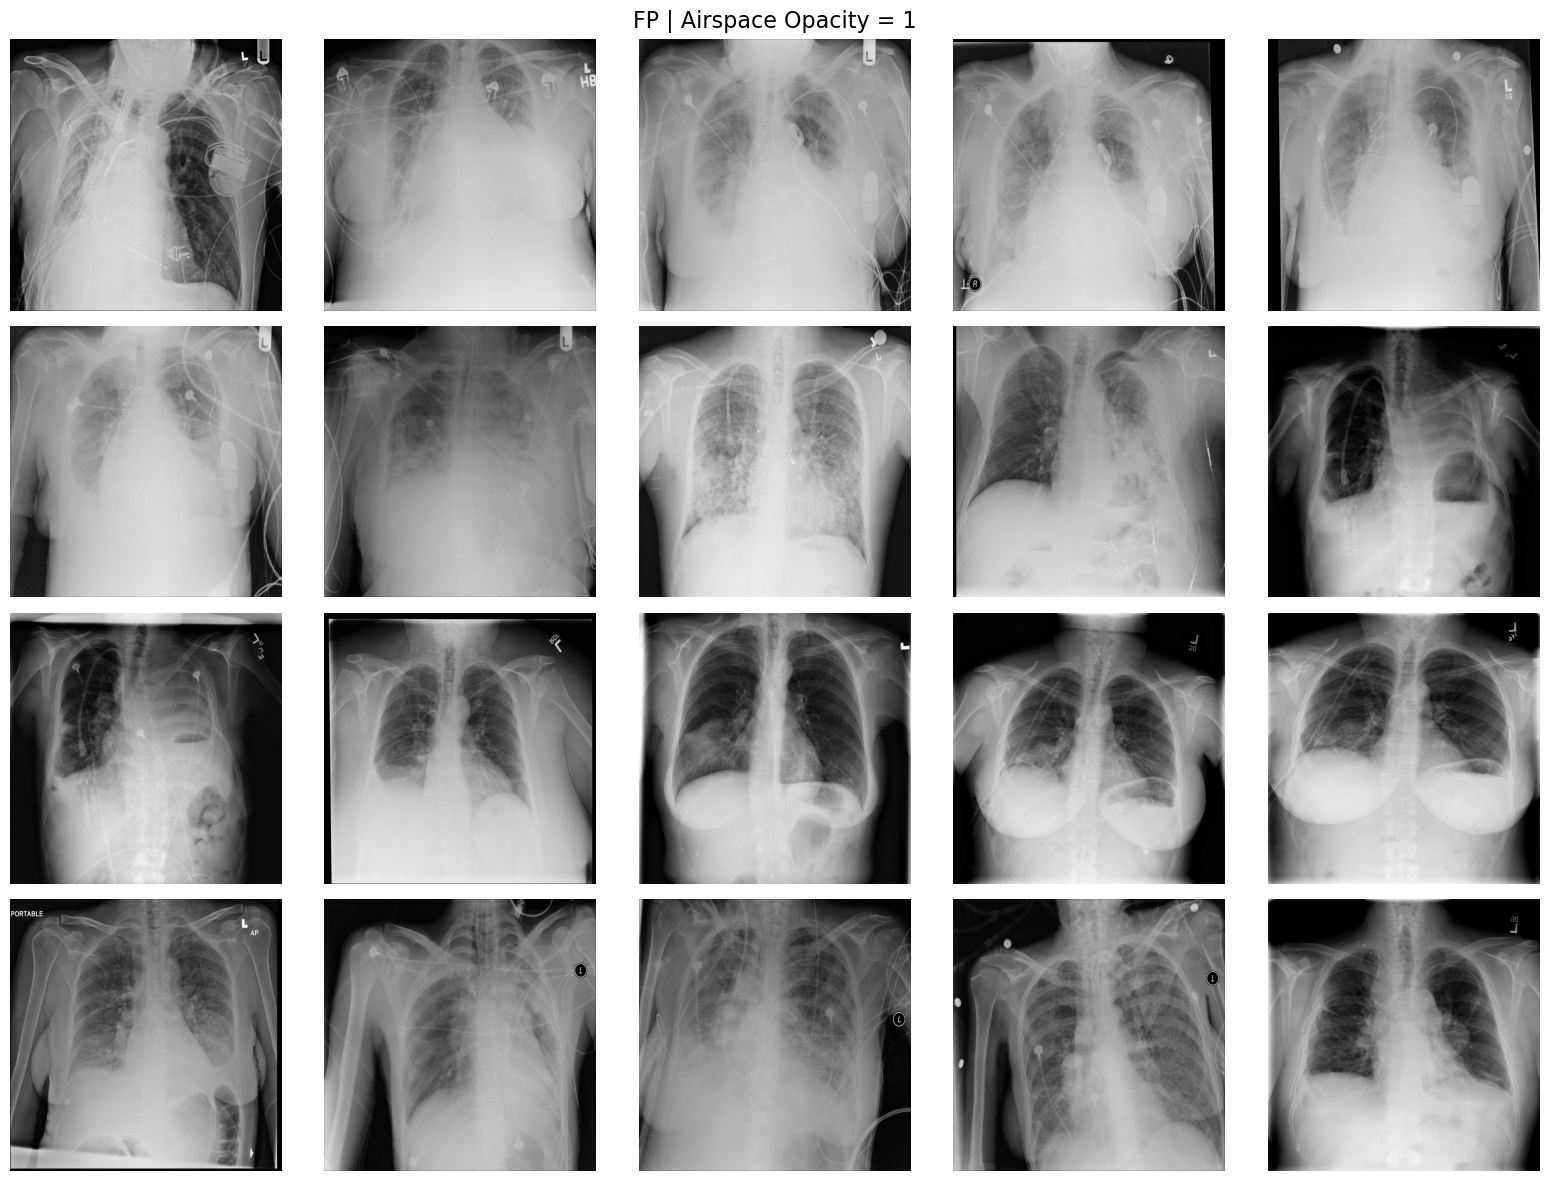

Displaying 222 FP images with Airspace Opacity = 0


Displaying 6 FN images with Airspace Opacity = 1


Displaying 2 FN images with Airspace Opacity = 0


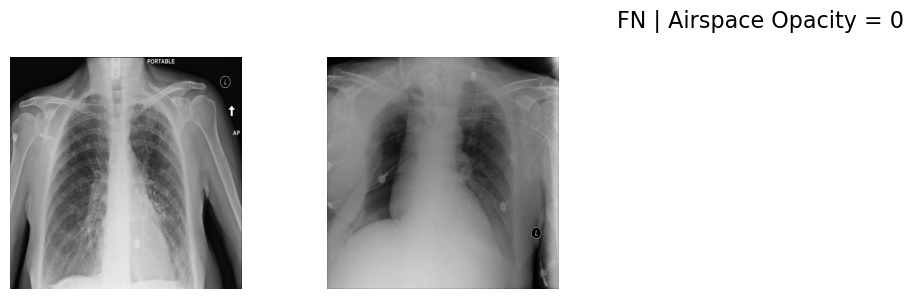

In [23]:
# False Positives WITH opacity
visualize_errors_by_opacity(test_out, image_dir="C:/Users/wangh/cxr14/images_all", error_type="FP", opacity=1)

# False Positives WITHOUT opacity
visualize_errors_by_opacity(test_out, image_dir="C:/Users/wangh/cxr14/images_all", error_type="FP", opacity=0)

# False Negatives WITH opacity
visualize_errors_by_opacity(test_out, image_dir="C:/Users/wangh/cxr14/images_all", error_type="FN", opacity=1)

# False Negatives WITHOUT opacity
visualize_errors_by_opacity(test_out, image_dir="C:/Users/wangh/cxr14/images_all", error_type="FN", opacity=0)

In [24]:
class DenseNet121FeatureExtractor(nn.Module):
    def __init__(self, weight_path, device):
        super().__init__()
        # Load base model
        base_model = models.densenet121(pretrained=True)
        num_ftrs = base_model.classifier.in_features
        base_model.classifier = nn.Linear(num_ftrs, 1)
        
        # Load your trained weights
        base_model.load_state_dict(torch.load(weight_path, map_location=device))
        self.features = base_model.features  # All conv blocks
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pool
        self.flatten = nn.Flatten()

        self.to(device)
        self.eval()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)  # Shape: [batch, 1024]
        return x


In [25]:
def extract_embeddings(model, dataloader, device):
    """
    Returns: dict { image_index: embedding_vector }
    """
    model.eval()
    embeddings = {}
    with torch.no_grad():
        for images, _, image_names in tqdm(dataloader, desc="Extracting embeddings"):
            images = images.to(device)
            feats = model(images).cpu().numpy()  # [batch_size, 1024]
            for i, name in enumerate(image_names):
                embeddings[name] = feats[i]
    return embeddings


In [26]:
feature_model = DenseNet121FeatureExtractor("121best_model.pt", device)
val_embeddings = extract_embeddings(feature_model, test_loader, device)

C:\Users\wangh\anaconda3\envs\mura-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wangh\anaconda3\envs\mura-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\wangh\AppData\Local\Temp\ipykernel_6520\1262393833.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.co

In [27]:
image_names = list(val_embeddings.keys())
embedding_matrix = np.stack(list(val_embeddings.values()))  # [N, 1024]

In [28]:
def run_pca_kmeans(embedding_matrix, image_names, n_clusters=10, pca_dim=50):
    # Step 1: PCA (optional but helps clustering)
    pca = PCA(n_components=pca_dim)
    reduced_embeddings = pca.fit_transform(embedding_matrix)

    # Step 2: KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(reduced_embeddings)

    # Step 3: Return DataFrame
    cluster_df = pd.DataFrame({
        "Image Index": image_names,
        "cluster": cluster_ids
    })
    return cluster_df, kmeans, pca


In [29]:
cluster_df, kmeans_model, pca_model = run_pca_kmeans(embedding_matrix, image_names, n_clusters=5, pca_dim=50)

C:\Users\wangh\anaconda3\envs\mura-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [30]:
audited_clustered = test_out.merge(cluster_df, on="Image Index", how="left")

In [31]:
audited_clustered

Image Index  true      pred          Finding Labels  Follow-up #  \
0     00000013_008.png   0.0  0.916198              No Finding            8   
1     00000013_026.png   1.0  0.958827  Cardiomegaly|Emphysema           26   
2     00000032_002.png   0.0  0.481196              No Finding            2   
3     00000032_009.png   0.0  0.213890              No Finding            9   
4     00000032_011.png   0.0  0.529672            Infiltration           11   
...                ...   ...       ...                     ...          ...   
1957  00030680_001.png   0.0  0.147149              No Finding            1   
1958  00030709_002.png   0.0  0.151218              No Finding            2   
1959  00030719_000.png   0.0  0.149138              No Finding            0   
1960  00030752_000.png   0.0  0.119792              No Finding            0   
1961  00030794_000.png   0.0  0.054145              No Finding            0   

      Patient ID  Patient Age Patient Gender View Position  \
0             13           60              M            AP   
1             13           57              M            AP   
2             32           55              F            AP   
3             32           55              F            AP   
4             32           55              F            AP   
...          ...          ...            ...           ...   
1957       30680           36              F            PA   
1958       30709           48              M            AP   
1959       30719           54              M            PA   
1960       30752           64              F            AP   
1961       30794           38              F            PA   

      OriginalImage[Width  ...        y]  Fracture  Pneumothorax  \
0                    3056  ...  0.139000        NO            NO   
1                    2500  ...  0.168000        NO           YES   
2                    2500  ...  0.168000        NO            NO   
3                    2500  ...  0.168000        NO            NO   
4                    2500  ...  0.168000        NO            NO   
...                   ...  ...       ...       ...           ...   
1957                 2021  ...  0.194311        NO            NO   
1958                 3056  ...  0.139000        NO            NO   
1959                 2021  ...  0.194311        NO            NO   
1960                 3056  ...  0.139000        NO            NO   
1961                 2021  ...  0.194311        NO            NO   

     Airspace opacity Nodule or mass  Set Id Label pred_label  error_type  \
0                   1             NO    test     0          1          FP   
1                   0             NO    test     1          1          TP   
2                   1             NO    test     0          0          TN   
3                   1             NO    test     0          0          TN   
4                   1             NO    test     0          1          FP   
...               ...            ...     ...   ...        ...         ...   
1957                0             NO    test     0          0          TN   
1958                0             NO    test     0          0          TN   
1959                0            YES    test     0          0          TN   
1960                0             NO    test     0          0          TN   
1961                0             NO    test     0          0          TN   

      cluster  
0           1  
1           1  
2           2  
3           2  
4           2  
...       ...  
1957        4  
1958        4  
1959        4  
1960        4  
1961        3  

[1962 rows x 22 columns]

In [32]:
audited_clustered.groupby("cluster")["error_type"].value_counts(normalize=True).unstack().fillna(0)

error_type        FN        FP        TN        TP
cluster                                           
0           0.000000  0.600000  0.000000  0.400000
1           0.000000  0.854086  0.000000  0.145914
2           0.012238  0.339161  0.631119  0.017483
3           0.000000  0.000000  1.000000  0.000000
4           0.002825  0.169492  0.816384  0.011299

In [34]:
for cluster_id in sorted(audited_clustered['cluster'].unique()):
    subset = audited_clustered[audited_clustered['cluster'] == cluster_id]
    auc = roc_auc_score(subset['true'], subset['pred'])
    print(f"Cluster {cluster_id}: AUC = {auc:.4f} | N = {len(subset)}")



Cluster 0: AUC = 0.6599 | N = 245
Cluster 1: AUC = 0.6812 | N = 514
Cluster 2: AUC = 0.6422 | N = 572
Cluster 3: AUC = nan | N = 277
Cluster 4: AUC = 0.8418 | N = 354


C:\Users\wangh\anaconda3\envs\mura-env\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [35]:
def plot_error_heatmap(audited_df, cluster_col='cluster', k=5):
    # Filter to the desired k
    df = audited_df.copy()
    cluster_counts = df[cluster_col].value_counts()
    clusters_to_plot = cluster_counts.nlargest(k).index  # ensure correct clusters if more than k exist
    df = df[df[cluster_col].isin(clusters_to_plot)]

    # Get counts of error types per cluster
    heatmap_df = (
        df.groupby(cluster_col)['error_type']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .loc[sorted(clusters_to_plot)]
    )

    # Plot heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.title(f"Error Type Distribution by Cluster (k={k})")
    plt.xlabel("Error Type")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()


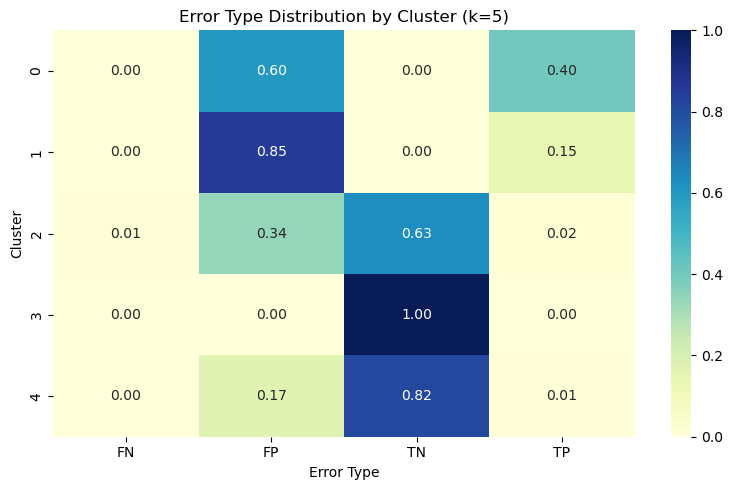

In [36]:
plot_error_heatmap(audited_clustered, cluster_col='cluster', k=5)
